# Examine the dynamics of viral escape from each antibody using mutation-level escape scores

## Import Python modules

In [1]:
import os
import sys
import glob
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm
%matplotlib inline
import seaborn as sns
sns.set_theme(font_scale=1.0, style='ticks', palette='colorblind')

import scipy.stats
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform, pdist, cdist
#import hdbscan
#import umap

#from Bio import SeqIO
import dmslogo

# Import custom script
sys.path.append('../scripts/')
import clusters

# Make figures directory
if not os.path.isdir('../results/figures_v2/'):
    os.makedirs('../results/figures_v2/')

## Read in data

Read in escape scores and DMS data

In [2]:
# Read in mutation-level DMS data from Cao et al. and compute normalized
# mutation-level escape scores
dms_df = (
    pd.read_csv('../convergent_RBD_evolution/use_res_clean.csv')
    .assign(site_escape = lambda x: x.groupby(['antibody', 'site'])['mut_escape'].transform(sum))
    .assign(max_site_escape = lambda x: x.groupby('antibody')['site_escape'].transform(max))
    .assign(normalized_mut_escape = lambda x: x['mut_escape'] / x['max_site_escape'])
    .rename(columns={'group' : 'epitope_cluster'})
)

# Make a shorter version of the above dataframe giving the epitope group of each ab
ab_group_df = dms_df.drop_duplicates('antibody')[['antibody', 'epitope_cluster']]

# Read in site-level escape scores
escape_calc_resultsdir = '../results/processed_input_data/'
site_escape_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'escape.csv'))

# Read in estimated escape scores for antibodies from Cao et al. and merge with data
# giving epitope groups
escape_scores_df = pd.read_csv('../results/predicted_escape_scores_v2/all_predictions.csv')
escape_scores_df = escape_scores_df.merge(ab_group_df, how='left')
escape_scores_df['epitope_cluster'].fillna('other', inplace=True)
escape_scores_df['escape_score'].clip(upper=1.0, inplace=True)
escape_scores_df['all_aa_substitutions'] = escape_scores_df['all_aa_substitutions'].fillna('')

# Rename some of the Nextstrain clade names, and consolidate the 21A/I/J Delta clades into one
escape_scores_df['clade'] = escape_scores_df['Nextstrain_clade']
escape_scores_df['clade'] = escape_scores_df['clade'].replace({
    '20E (EU1)' : '20E',
    '20H (Beta, V2)' : '20H (Beta)',
    '20I (Alpha, V1)' : '20I (Alpha)',
    '20J (Gamma, V3)' : '20J (Gamma)',
    '21A (Delta)' : '21A/I/J (Delta)',
    '21I (Delta)' : '21A/I/J (Delta)',
    '21J (Delta)' : '21A/I/J (Delta)',
    '21K (Omicron)' : '21K (BA.1)',
    '21L (Omicron)' : '21L (BA.2)',
    '22A (Omicron)' : '22A (BA.4)',
    '22B (Omicron)' : '22B (BA.5)',
    '22C (Omicron)' : '22C (BA.2.12.1)',
    '22D (Omicron)' : '22D (BA.2.75)',
    '22E (Omicron)' : '22E (BQ.1)',
    '22F (Omicron)' : '22F (XBB)',
    '23A (Omicron)' : '23A (XBB.1.5)',
    '23B (Omicron)' : '23B (XBB.1.16)',
    '23D (Omicron)' : '23D (XBB.1.9)',
    '23E (Omicron)' : '23E (XBB.2.3)',
})
def get_short_clade_name(x):
    return x.split(' ')[0]
escape_scores_df['clade_short'] = escape_scores_df['clade'].apply(lambda x: get_short_clade_name(x))

abs_with_predictions = escape_scores_df["antibody"].unique()
print(f'Read in predicted escape scores for {len(abs_with_predictions)} antibodies')

Read in predicted escape scores for 1609 antibodies


Read in IC50 data

In [3]:
# Read in IC50 data from Cao et al.
ic50s_df = pd.read_csv(os.path.join(
    escape_calc_resultsdir, 'antibody_IC50s.csv'
))
ic50s_df['study'] = 'Cao et al.'

# Read in IC50 data from Wang et al.
cols = [
    'antibody', 'Spike', 'RBD', 'NTD',
    'av_D614G', 'av_Beta', 'av_Gamma', 'av_Delta', 'av_Omicron',
    'pv_D614G', 'pv_Alpha', 'pv_Beta', 'pv_Gamma', 'pv_Delta',
    'pv_Lamda', 'pv_Omicron',
    'BLI'
]
wang_ic50s_df = pd.read_excel('../data/Wang_ic50_values.xlsx', skiprows=3, names=cols)
wang_ic50s_df = (
    wang_ic50s_df[
        (wang_ic50s_df['antibody'].str.contains('data referenced') == False)
    ]
    .dropna(subset='antibody')
    .replace('>50', '50')
    .replace('>10', 10)
    .replace('NS', np.nan)
    .replace('-', np.nan)
)
wang_ic50s_df['antibody'] = wang_ic50s_df['antibody'].apply(
    lambda x: x.replace('*', '').replace('XGv', 'XGv-')
)

# For Wang et al., record IC50s for both authentic virus (av) and pseudovirus (pv)
dfs = [ic50s_df]
for virus_type in ['av', 'pv']:
    vt_cols = [col for col in wang_ic50s_df if virus_type in col]
    vt_ic50s_df = wang_ic50s_df[['antibody']+vt_cols].copy()
    vt_ic50s_df.rename(columns={
        col : col.replace(f'{virus_type}_', '')
        for col in vt_ic50s_df
    }, inplace=True)
    value_vars = [col for col in vt_ic50s_df if col != 'antibody']
    vt_ic50s_df = vt_ic50s_df.melt(
        id_vars='antibody', value_vars=value_vars,
        var_name='virus', value_name='IC50'
    )
    vt_ic50s_df['IC50'] = vt_ic50s_df['IC50'].astype(float)
    vt_ic50s_df['study'] = f'Wang et al. {virus_type}'
    vt_ic50s_df['virus'].replace({
        'Omicron':'BA.1',
        'Lamda':'Lambda',
    }, inplace=True)
    dfs.append(vt_ic50s_df)
    
ic50s_df = pd.concat(dfs)
ic50s_df['log_IC50'] = ic50s_df['IC50'].apply(lambda x: np.log10(x))

# Merge with data on antibody source and antibody group, and subset to antibodies
# with predicted escape scores
ab_source_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'antibody_sources.csv'))
ic50s_df = (
    ic50s_df[ic50s_df['antibody'].isin(abs_with_predictions)]
    .merge(
        ab_source_df[ab_source_df['study'] == 'imprinted_2022'][['antibody', 'source']],
        on='antibody', how='left'
    )
    .merge(ab_group_df, on='antibody', how='left')
)

# For each antibody from each study, compute the change in log IC50 value for a
# given virus relative to the D614G virus
init_data = (
    ic50s_df[ic50s_df['virus'] == 'D614G'][['antibody', 'study', 'log_IC50']]
    .copy()
    .rename(columns={'log_IC50':'init_log_IC50'})
)
if 'init_log_IC50' not in ic50s_df.columns.values:
    ic50s_df = ic50s_df.merge(
        init_data, on=['antibody', 'study'], how='left', validate='many_to_one'
    )
    ic50s_df['delta_log_IC50'] = ic50s_df['log_IC50'] - ic50s_df['init_log_IC50']


# Make a dataframe with IC50s against D614G
init_ic50s_df = ic50s_df[
    (ic50s_df['virus'] == 'D614G') &
    (ic50s_df['study'] == 'Cao et al.')
].copy()
init_ic50s_df['IC50_weight'] = init_ic50s_df['IC50'].apply(lambda x: -np.log10(x/10))

print('Read in IC50 data for this many antibodies from each study')
display(ic50s_df.drop_duplicates(['study', 'antibody'])['study'].value_counts())

print('This many antibodies came from each of the following groups of patients')
display(ic50s_df.drop_duplicates('antibody')['source'].value_counts().loc[['WT vaccinees', 'WT convalescents', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']])

Read in IC50 data for this many antibodies from each study


Cao et al.        1603
Wang et al. av      90
Wang et al. pv      90
Name: study, dtype: int64

This many antibodies came from each of the following groups of patients


WT vaccinees          205
WT convalescents      321
BA.1 convalescents    462
BA.2 convalescents    470
BA.5 convalescents    145
Name: source, dtype: int64

## Compute how escape scores, mutation frequencies, and clade frequencies change over time

In a sliding window of 0.2 years that tiles across the phylogeny of viruses, we take all viruses within the window and compute the following things:
* for each antibody, the average escape score of each virus for that antibody. The resulting sliding-window average defines the virus's escape trajectory.
* the frequency of mutations at sites of escape in the RBD protein sequence 
* the frequency of clades

In [4]:
# Define parameters of sliding windows
start_time = escape_scores_df['year'].min()
end_time = escape_scores_df['year'].max()
window_width = 0.2
window_step_size = 0.1

# Make a list of sliding windows, recording the time corresponding to the left
# side of each window
left_side_of_window = start_time
list_of_left_sides_of_windows = []
while left_side_of_window <= end_time:
    list_of_left_sides_of_windows.append(left_side_of_window)
    left_side_of_window = left_side_of_window + window_step_size

# Get a list of all sites with mutations
all_mut_sites = []
all_subs = set(escape_scores_df[
    escape_scores_df['all_aa_substitutions'].notnull()
]['all_aa_substitutions'])
for subs in all_subs:
    if subs == '':
        continue
    subs = subs.split(' ')
    for sub in subs:
        all_mut_sites.append(int(sub[1:-1]))
all_mut_sites = sorted(list(set(all_mut_sites)))

# Initiate a series with zero counts for each clade
clade_zeros_dict = {
    clade : 0
    for clade in escape_scores_df['clade'].unique()
}
clade_zeros_series = pd.Series(clade_zeros_dict)
clade_freqs_dict = defaultdict(list)

# For each window:
# i) for each antibody, record the average escape score of all viruses within each window
# ii) record the frequency of mutations at each site
# iii) record the frequency of each clade
mut_freq_dict = defaultdict(list)
dfs = []
for left_side_of_window in list_of_left_sides_of_windows:

    right_side_of_window = left_side_of_window + window_width
    center_of_window = left_side_of_window + (window_width / 2)
       
    # Get data for all viruses in the window, and then compute their mean escape score
    # relative to each antibody
    data = (
        escape_scores_df[(escape_scores_df['year'].between(left_side_of_window, right_side_of_window))]
        .groupby(['antibody', 'epitope_cluster'], as_index=False)['escape_score'].mean(numeric_only=True)
        .assign(time=center_of_window-start_time)
        .assign(year=center_of_window)
    )
    dfs.append(data)

    # Get data for all unique viruses within a given window then record the frequency of
    # each mutation
    data = escape_scores_df[
        (escape_scores_df['year'].between(left_side_of_window, right_side_of_window))
    ].drop_duplicates('strain').copy()
    data['all_aa_substitutions'].fillna('', inplace=True)
    for mut_site in all_mut_sites:
        mut_freq_dict['time'].append(center_of_window-start_time)
        mut_freq_dict['year'].append(center_of_window)
        mut_freq_dict['site'].append(mut_site)
        mut_freq_dict['mut_freq'].append(
            sum(data['all_aa_substitutions'].str.contains(r'\D{0}\D'.format(mut_site))) / len(data)
        )

    # ... also record clade frequencies
    clade_counts = (data['clade'].value_counts() + clade_zeros_series).fillna(0)
    clade_freqs = clade_counts / clade_counts.sum()
    for (clade, freq) in clade_freqs.items():
        clade_freqs_dict['clade'].append(clade)
        clade_freqs_dict['freq'].append(freq)
        clade_freqs_dict['time'].append(center_of_window-start_time)
        clade_freqs_dict['year'].append(center_of_window)
           
# Compile escape trajectories
traj_df = pd.concat(dfs)
traj_df.rename(columns={'escape_score' : 'mean_escape'}, inplace=True)

# Add columns to escape_df that give antibody metadata relative to the D614G strain
traj_df = traj_df.merge(
    init_ic50s_df[['antibody', 'IC50', 'IC50_weight', 'log_IC50', 'source']],
    on='antibody', how='left'
)
traj_df['wtd_escape_score'] = traj_df['mean_escape'] * traj_df['IC50_weight']

# Complie the frequencies of mutations and clades over time
mut_freq_df = pd.DataFrame(mut_freq_dict)
clade_freqs_df = pd.DataFrame(clade_freqs_dict)

Plot the change in escape score over time, averaged across all antibodies

Showing data from these sources: ['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


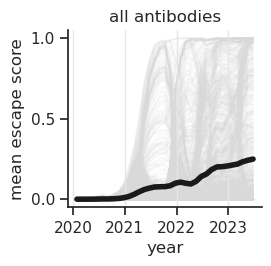

In [5]:
# Plot total escape over time
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents',
]
print('Showing data from these sources:', sources)
metric = 'mean_escape' # 'wtd_escape_score' # 
data = (
    traj_df[traj_df['source'].isin(sources)]
    .groupby('year', as_index=False)[[metric]].mean()
)
#data[metric] = data[metric] / data[metric].max()
plt.figure(figsize=[2.5,2.3])
sns.lineplot(x='year', y=metric, data=data, linewidth=4, color='k')
data = traj_df[traj_df['source'].isin(sources)]
sns.lineplot(
    data=data, x="year", y="mean_escape", units='antibody',
    estimator=None, color=".85", linewidth=1, zorder=0, alpha=0.1
)
plt.grid(axis='x', color='0.9')
plt.title('all antibodies')
plt.yticks([0, 0.5, 1.0])
plt.ylabel('mean escape score')
sns.despine()
# plt.savefig(f'../results/figures/average_trajectory_all_antibodies.png', dpi=300, bbox_inches='tight')
plt.show()

Show the escape trajectory for a single antibody of interest

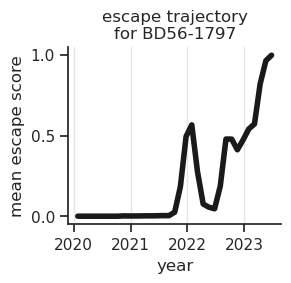

In [6]:
antibody_to_plot = 'BD56-1797' # 'LY-CoV555' # 'BD-744'
data = traj_df[traj_df['antibody'] == antibody_to_plot]
plt.figure(figsize=[2.75,2.3])
sns.lineplot(x='year', y='mean_escape', data=data, linewidth=4, color='k')
plt.grid(axis='x', color='0.9')
plt.title(f'escape trajectory\nfor {antibody_to_plot}')
plt.yticks([0, 0.5, 1.0])
plt.ylabel('mean escape score')
sns.despine()
# plt.savefig(f'../results/figures/trajectory_for_{antibody_to_plot}.png', dpi=300, bbox_inches='tight')
plt.show()

How many times does a site have data for at least one mutation across all antibodies?

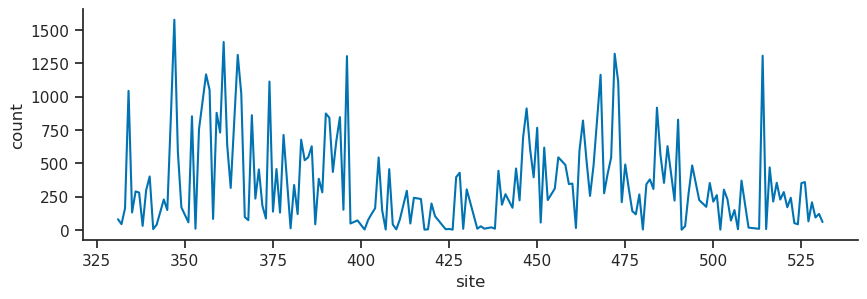

In [7]:
data = dms_df.drop_duplicates(subset=['site', 'antibody'])['site'].value_counts().reset_index()
data.columns = ['site', 'count']
plt.figure(figsize=[10,3])
sns.lineplot(x='site', y='count', data=data)
sns.despine()
plt.show()

In [8]:
data['site'].min(), data['site'].max()

(331, 531)

## Cluster antibodies by escape trajectory

In [9]:
# Get data
escape_matrix = (
    traj_df
    .pivot_table(index='antibody', columns='year', values='mean_escape')
    #.clip(upper=0.8)
)

# Cluster trajectories
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(escape_matrix)
escape_matrix['kmeans_cluster'] = kmeans.labels_

Use k-means clustering to group antibodies into 20 clusters

In [10]:
# Get data
escape_matrix = traj_df.pivot_table(index='antibody', columns='year', values='mean_escape')

# Cluster trajectories
n_clusters = 20 # 10 # 
kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(escape_matrix)
escape_matrix['kmeans_cluster'] = kmeans.labels_

# Consolidate the 20 clusters into 10 clusters
manual_clusters = {
    0 : 10,
    1 : 5,
    2 : 3,
    3 : 8,
    4 : 2,
    5 : 1,
    6 : 4,
    7 : 4,
    8 : 2,
    9 : 10,
    10 : 2,
    11 : 1,
    12 : 7,
    13 : 6,
    14 : 4,
    15 : 2,
    16 : 6,
    17 : 9,
    18 : 10,
    19 : 2
}
assert len(manual_clusters) == 20
escape_matrix['escape_cluster'] = escape_matrix['kmeans_cluster'].apply(lambda x: manual_clusters[x])

# Merge cluster data with the escape-trajectory data and IC50 data
if 'kmeans_cluster' not in traj_df.columns.values:
    data_to_merge = escape_matrix.reset_index()[['antibody', 'kmeans_cluster', 'escape_cluster']]
    traj_df = traj_df.merge(data_to_merge, on='antibody', how='left')
    ic50s_df = ic50s_df.merge(data_to_merge, on='antibody', how='left')
    init_ic50s_df = init_ic50s_df.merge(data_to_merge, on='antibody', how='left')
    dms_df = dms_df.merge(data_to_merge, on='antibody', how='inner')
    site_escape_df = site_escape_df.merge(data_to_merge, on='antibody', how='left')

Plot clusters of antibodies. First, plot the 20 clusters from k means clustering

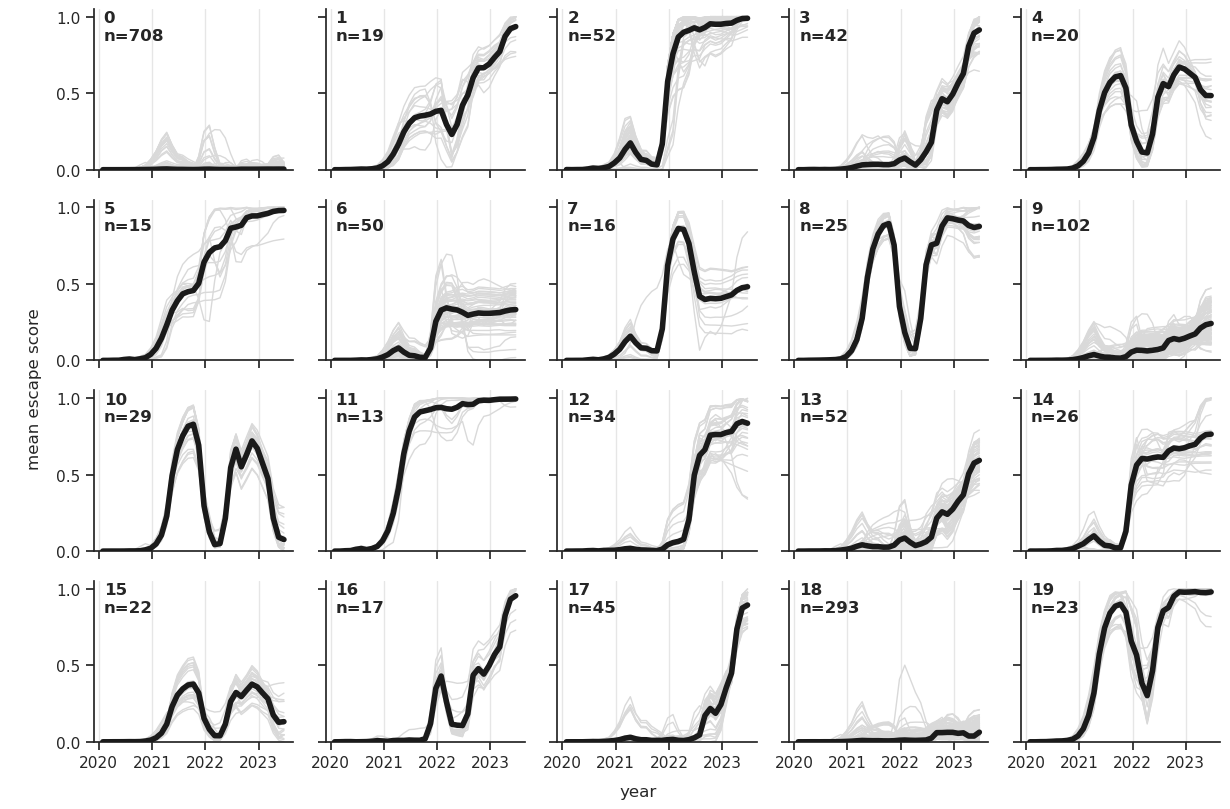

In [11]:
# Plot each antibody group's time series in its own facet
cluster_to_plot = 'kmeans_cluster' # 'escape_kmeans_groups' # 
data_to_plot = traj_df.copy()
data_to_plot['escape_kmeans_groups'] = data_to_plot.apply(
    lambda row: str(int(row['escape_cluster'])) + ', kmeans ' + str(int(row['kmeans_cluster'])),
    axis=1
)
data = data_to_plot.groupby([cluster_to_plot, 'year']).mean(numeric_only=True).reset_index()
data.sort_values('escape_cluster', inplace=True)
g = sns.relplot(
    data=data,
    x="year", y="mean_escape", col=cluster_to_plot,
    kind="line", color='k', # hue=cluster_to_plot, palette="crest",
    linewidth=4, zorder=5,
    col_wrap=5, height=2, aspect=1.2,
    legend=False,
)

# Then plot other antibodies from group or other antibody groups in the background
groupby_cols = [
    'antibody',
    cluster_to_plot,
    'year'
]
for group, ax in g.axes_dict.items():
    data = data_to_plot[
        ~(data_to_plot['antibody'].str.contains('Starr')) &
        ~(data_to_plot['antibody'].str.contains('Dong')) &
        (data_to_plot[cluster_to_plot] == group)
    ].groupby(groupby_cols).mean(numeric_only=True).reset_index()
    sns.lineplot(
        data=data, x="year", y="mean_escape", units=groupby_cols[0],
        estimator=None, color=".85", linewidth=1, ax=ax
    )
    
    n_abs = data['antibody'].nunique()
    #group_title = group[:2].replace(',', '')
    ax.text(.05, .81, f'{group}\nn={n_abs}', transform=ax.transAxes, fontweight="bold")
    ax.set(xticks=[2020, 2021, 2022, 2023], yticks=[0,0.5,1], ylim=[0,1.05])
    ax.grid(axis='x', color='0.9')

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'year', ha='center')
g.fig.text(-0.01, 0.5, '\nmean escape score', va='center', ha='center', rotation='vertical')
g.tight_layout()
# plt.savefig(f'../results/figures/trajectories_kmeans.png', dpi=300, bbox_inches='tight')
plt.show()

Next, plot the 8 consolidated clusters

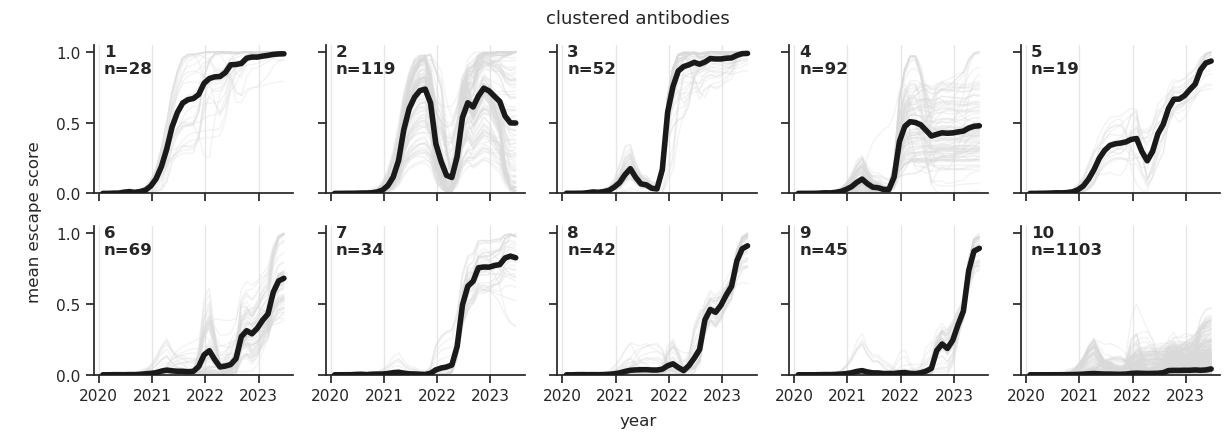

In [12]:
# Plot each antibody group's time series in its own facet
cluster_to_plot = 'escape_cluster' # 'epitope_cluster' # 
data = (
    traj_df[traj_df['epitope_cluster'] != 'other']
    .groupby([cluster_to_plot, 'year']).mean(numeric_only=True)
    .reset_index()
)
data.sort_values(cluster_to_plot, inplace=True)
g = sns.relplot(
    data=data,
    x="year", y="mean_escape", col=cluster_to_plot,
    kind="line", color='k', # hue=cluster_to_plot, palette="crest", 
    linewidth=4, zorder=5,
    col_wrap=5, height=2, aspect=1.2,
    legend=False,
)

# Then plot other antibodies from group or other antibody groups in the background
groupby_cols = [
    'antibody',
    cluster_to_plot,
    'year'
]
for group, ax in g.axes_dict.items():
    data = traj_df[
        ~(traj_df['antibody'].str.contains('Starr')) &
        ~(traj_df['antibody'].str.contains('Dong')) &
        (traj_df[cluster_to_plot] == group)
    ].groupby(groupby_cols).mean(numeric_only=True).reset_index()
    sns.lineplot(
        data=data, x="year", y="mean_escape", units=groupby_cols[0],
        estimator=None, color=".85", linewidth=1, ax=ax, alpha=0.3
    )
    
    n_abs = data['antibody'].nunique()
    ax.text(.05, .81, f'{group}\nn={n_abs}', transform=ax.transAxes, fontweight="bold")
    ax.set(xticks=[2020, 2021, 2022, 2023], yticks=[0,0.5,1], ylim=[0,1.05])
    ax.grid(axis='x', color='0.9')

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'year', ha='center')
g.fig.text(-0.01, 0.5, '\nmean escape score', va='center', ha='center', rotation='vertical')
g.tight_layout()
plt.suptitle('clustered antibodies', y=1.03, fontsize=13)
# plt.savefig(f'../results/figures/trajectories_of_{cluster_to_plot}.png', dpi=300, bbox_inches='tight')
plt.show()

Make a list of sites that appear to drive escape in each cluster based on the above analyses. Then, for each cluster, plot the change in frequency of mutations at those sites over time.

/tmp/ipykernel_912265/1127407102.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


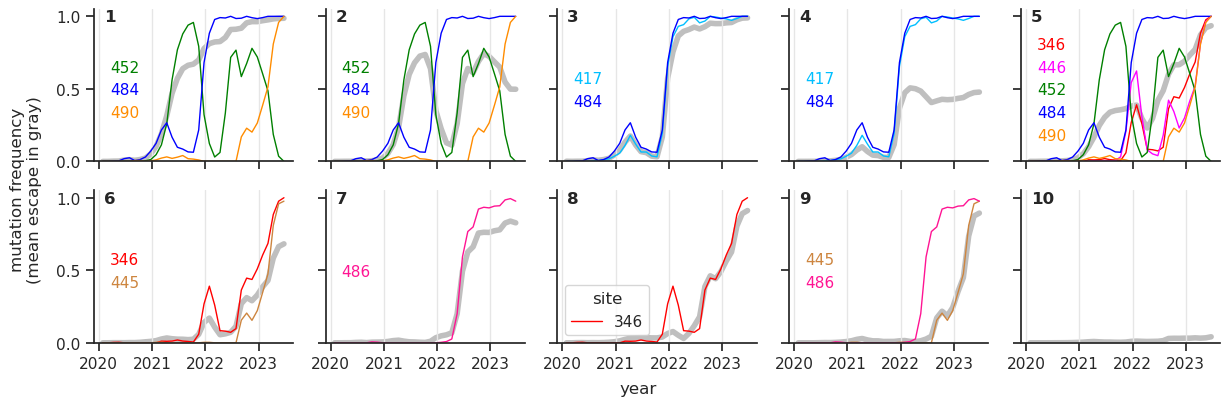

In [13]:
# Identify key sites of escape
key_sites_per_cluster = {}
for cluster in range(1,11):
    data = (
        site_escape_df
        .merge(mut_freq_df.groupby('site', as_index=False)['mut_freq'].max(), on='site', how='inner')
        .query("escape_cluster == @cluster")
    )
    nabs = data['antibody'].nunique()
    data = data[
        (data['normalized_escape'] > 0.4) &
        (data['mut_freq'] > 0.9)
    ]
    site_counts = data['site'].value_counts()
    site_counts = site_counts[site_counts > nabs/4]
    key_sites = list(site_counts.index.values)
    key_sites_per_cluster[cluster] = key_sites

# Plot each antibody group's time series in its own facet
cluster_to_plot = 'escape_cluster'
mut_palette = {
    452 : 'green',
    484 : 'blue',
    490 : 'darkorange',
    417 : 'deepskyblue',
    376 : 'firebrick',
    405 : 'brown',
    408 : 'maroon',    
    346 : 'red',
    446 : 'magenta',
    445 : 'peru',
    486 : 'deeppink',
}
data = (
    traj_df[
        ~(traj_df['antibody'].str.contains('Starr')) &
        ~(traj_df['antibody'].str.contains('Dong'))
    ]
    .groupby([cluster_to_plot, 'year']).mean(numeric_only=True).reset_index()
)
data.sort_values(cluster_to_plot, inplace=True)
g = sns.relplot(
    data=data,
    x="year", y="mean_escape", col=cluster_to_plot,
    kind="line", color='0.75', #palette="crest", # 'husl', 
    linewidth=4, zorder=0,
    col_wrap=5, height=2, aspect=1.2,
    legend=False,
)

# Then plot mutation frequencies
groupby_cols = [
    cluster_to_plot,
    'time'
]
for (group, ax) in g.axes_dict.items():
    data = mut_freq_df[mut_freq_df['site'].isin(key_sites_per_cluster[group])]
    if len(data) > 0:
        g_i = sns.lineplot(
            data=data, x="year", y="mut_freq", units='site',
            estimator=None, linewidth=1, ax=ax, palette=mut_palette,
            hue='site'
        )    
    ax.set(xticks=[2020, 2021, 2022, 2023], yticks=[0,0.5,1], ylim=[0,1.05])
    ax.text(.05, .92, group, transform=ax.transAxes, fontweight="bold")
    ax.grid(axis='x', color='0.9')
    if group == 8:
        continue
    g_i.legend_.set_title(None)
    ax.legend(
        frameon=False, handlelength=0, labelcolor='linecolor',
        loc='center left', bbox_to_anchor=(-0.05,0.47)
    )

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'year', ha='center')
g.fig.text(-0.01, 0.5, 'mutation frequency\n(mean escape in gray)', va='center', ha='center', rotation='vertical')
g.tight_layout()
# plt.savefig(f'../results/figures/mut_freq_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

Plot the composition of epitopes in each escape cluster.

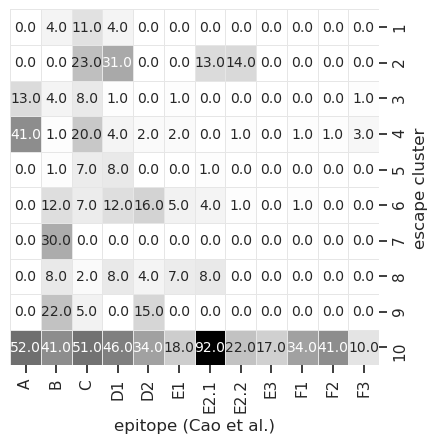

In [14]:
# Get a matrix with the number of antibodies in epitope clusters from Cao et al. vs.
# escape clusters computed here
neut_abs = init_ic50s_df[init_ic50s_df['log_IC50'] < 0]['antibody']
data = (
    # traj_df[
    #     (traj_df['antibody'].isin(neut_abs)) &
    #     ~(traj_df['antibody'].str.contains('Starr')) &
    #     ~(traj_df['antibody'].str.contains('Dong'))
    # ]
    # .drop_duplicates(subset='antibody')
    init_ic50s_df[init_ic50s_df['log_IC50'] < 0]
    .groupby(['epitope_cluster', 'escape_cluster'], as_index=False)['antibody'].count()
    .pivot_table(
        index='epitope_cluster', columns='escape_cluster',
        values='antibody'
    )
    .fillna(0)
    #.apply(lambda col: 100 * col/col.sum())
).T

# Plot the data
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data, annot=True, fmt=".1f",
    row_cluster=False, col_cluster=False, cmap=cmap,
    figsize=(5.5,5.5), annot_kws={"size": 10}, linewidths=0.5, linecolor='0.9'
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set(
    xlabel='epitope (Cao et al.)', ylabel='escape cluster'
)
#ax.set_title('percent composition by row', y=1.02)
plt.show()

For each prominent epitope in each cluster, plot average site-level escape scores at sites of strong escape

26


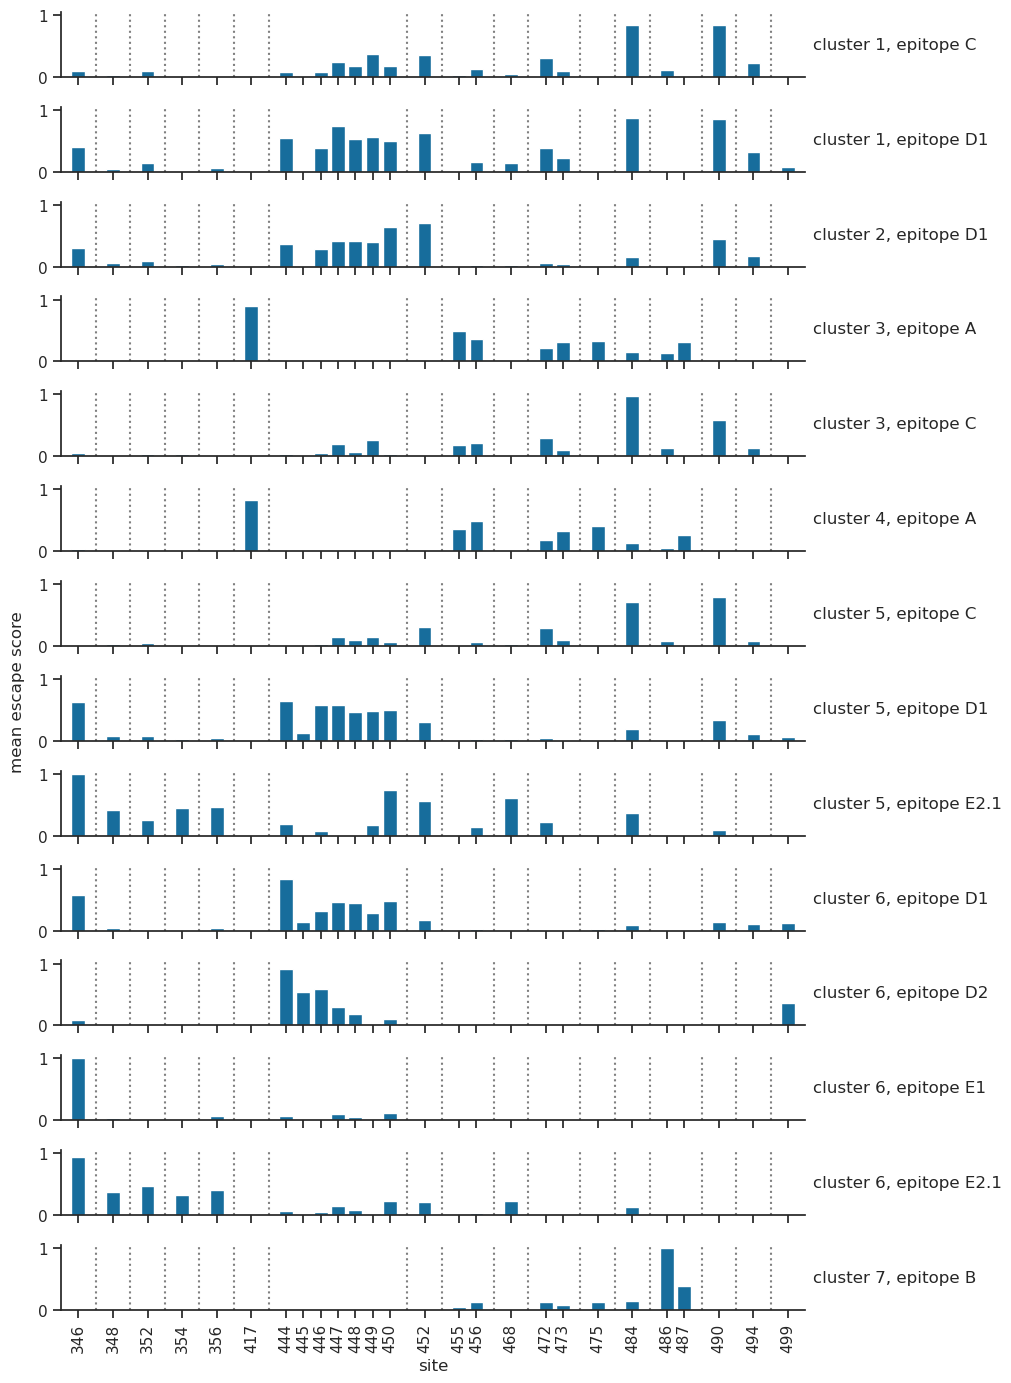

In [15]:
# Get data to plot
groups_to_plot = [
    (1, 'C'),
    (1, 'D1'),

    (2, 'D1'),
    
    (3, 'A'),
    (3, 'C'),

    (4, 'A'),

    (5, 'C'),
    (5, 'D1'),
    (5, 'E2.1'),

    (6, 'D1'),
    (6, 'D2'),
    (6, 'E1'),
    (6, 'E2.1'),

    (7, 'B'),

    # (8, 'A'),
    # (8, 'D1'),
    # (8, 'E2.1'),
    # (8, 'F1'),
    # (8, 'F2'),
]

data_to_plot = (
    ic50s_df
    .drop_duplicates('antibody')[['antibody', 'escape_cluster', 'epitope_cluster']]
    #.query("epitope_cluster == 'D1'")
    .merge(site_escape_df[['antibody', 'site', 'normalized_escape']], on='antibody')
)
data_to_plot['group'] = data_to_plot.apply(lambda row: (row['escape_cluster'], row['epitope_cluster']), axis=1)
data_to_plot = data_to_plot[data_to_plot['group'].isin(groups_to_plot)]

# Add entries of zero for missing sites
null_dict = defaultdict(list)
for site in data_to_plot['site'].unique():
    null_dict['site'].append(site)
    null_dict['normalized_escape'].append(0.0)
null_df = pd.DataFrame(null_dict)
dfs = []
for ((group, ab), ab_data) in data_to_plot.groupby(['group', 'antibody']):
    null_data = null_df.copy()
    null_data['group'] = [group] * len(null_data)
    null_data['antibody'] = ab
    ab_data = (
        pd.concat([null_data, ab_data])
        .groupby(['group', 'antibody', 'site'], as_index=False)['normalized_escape'].sum()
    )
    dfs.append(ab_data)
data_to_plot = pd.concat(dfs)

# Average scores across all antibodies in a group
data_to_plot = (
    data_to_plot
    .groupby(['group', 'site'], as_index=False)
    .agg(mean_normalized_escape = ('normalized_escape', 'mean'))
    .assign(group_title = lambda x: x['group'].map(lambda y: f'cluster {y[0]}, epitope {y[1]}'))
)

# Identify which sites to plot and subset data to only include those sites
sites_to_plot = list(data_to_plot[data_to_plot['mean_normalized_escape'] > 0.3]['site'].unique())
print(len(sites_to_plot))
data_to_plot = data_to_plot[
    (data_to_plot['site'].isin(sites_to_plot))
]

# Make a list of ticks to plot
ticks_to_sites = defaultdict(list)
ticks_to_plot = []
extra_ticks = []
tick = 0
last_site = -100
for (i, site) in enumerate(data_to_plot['site'].unique()):
    if (site -1 != last_site) and (i != 0):
        extra_ticks.append(tick)
        ticks_to_sites['site'].append(-1)
        ticks_to_sites['tick'].append(tick)
        tick += 1
    ticks_to_plot.append(tick)
    ticks_to_sites['site'].append(site)
    ticks_to_sites['tick'].append(tick)
    last_site = site
    tick += 1

ticks_to_sites = pd.DataFrame(ticks_to_sites)

# Plot data
ngroups = data_to_plot['group'].nunique()
(fig, axs) = plt.subplots(
    nrows=ngroups, sharex=True, sharey=True,
    figsize=[10,ngroups]
)

for (i, (group_title, data)) in enumerate(data_to_plot.groupby('group_title')):
    data = (
        data
        .merge(
            ticks_to_sites.assign(group_title = group_title),
            how='outer'
        )
        .fillna(0)
    )
    sns.barplot(x='tick', y='mean_normalized_escape', data=data, ax=axs[i])
    for tick in extra_ticks:
        axs[i].axvline(tick, ls='dotted', c='0.5')
    #axs[i].annotate(group_title, xy=(0.8, .975), transform=ax.transAxes)
    axs[i].text(1.01, 0.5, group_title, horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes)
    axs[i].set(ylabel='', xlim=[-1,ticks_to_plot[-1]+1])
    axs[i].set_xticks(ticks_to_plot)
    axs[i].set_xticklabels(data[data['site'] > 0]['site'].unique(), rotation=90)

plt.tight_layout()
axs[i].set(xlabel='site')
fig.text(-0.01, 0.5, 'mean escape score', va='center', rotation='vertical')
sns.despine()
# plt.savefig(f'../results/figures/dms_profiles_by_group.png', dpi=300, bbox_inches='tight')
plt.show()

For a given set of clusters (either epitope or escape), plot the number of antibodies in per cluster and the distribution of their IC50s.

Showing data for 1603 antibodies from the following sources: ['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


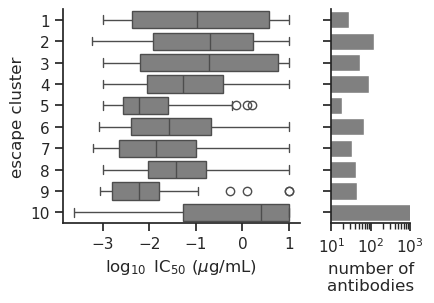

In [16]:
# Get input data
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 
    'BA.2 convalescents', 'BA.5 convalescents',
]
data = init_ic50s_df[init_ic50s_df['source'].isin(sources)].copy()
print(f'Showing data for {len(data)} antibodies from the following sources:', sources)

# Plot the data
cluster_col = 'escape_cluster' # 'epitope_cluster' # 
ic50_metric = 'log_IC50' # 'IC50_weight' # 
data.sort_values(cluster_col, inplace=True)
(fig, axs) = plt.subplots(
    ncols=2, figsize=[4.5,3.2], # [4.5,4], # 
    sharey=True,
    gridspec_kw={'width_ratios': [3, 1]}
)
sns.boxplot(
    x=ic50_metric, y=cluster_col, data=data,
    orient='h', color='0.5', #hue=cluster_col, palette='crest',
    legend=False, ax=axs[0]
)
# sns.pointplot(
#     x=ic50_metric, y=cluster_col, data=data,
#     orient='h', ax=axs[0],
#     estimator=np.median, errorbar=None, linestyle='none',
#     markers="o", color='w', markersize=5, 
# )
ylabel = cluster_col.replace('_', ' ')
if cluster_col == 'epitope_cluster':
    ylabel = 'epitope (Cao et al.)'
axs[0].set(
    ylabel=ylabel, xlabel=r'$\log_{10}$ IC$_{50}$ ($\mu$g/mL)',
    xticks=[-3, -2, -1, 0, 1]
)
sns.countplot(
    y=cluster_col, data=data,
    color='0.5', #hue=cluster_col, palette='crest',
    legend=False, ax=axs[1]
)
axs[1].set(
    xlabel='number of\nantibodies', ylabel='',
    xscale='log', xlim=[10,1000]
)
plt.tight_layout()
sns.despine()
# plt.savefig(f'../results/figures/antibody_stats_{cluster_col}.png', dpi=300, bbox_inches='tight')
plt.show()

Make a heatmap showing how many antibodies from a given epitope cluster fall in a given escape cluster.

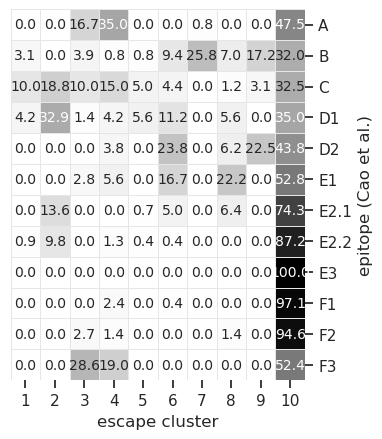

In [17]:
# Get a matrix with the number of antibodies in epitope clusters from Cao et al. vs.
# escape clusters computed here
data = (
    traj_df[
        ~(traj_df['antibody'].str.contains('Starr')) &
        ~(traj_df['antibody'].str.contains('Dong'))
    ]
    .drop_duplicates(subset='antibody')
    .groupby(['epitope_cluster', 'escape_cluster'], as_index=False)['antibody'].count()
    .pivot_table(
        index='escape_cluster', columns='epitope_cluster',
        values='antibody'
    )
    .fillna(0)
    .apply(lambda col: 100 * col/col.sum())
).T

# Plot the data
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data, annot=True, fmt=".1f",
    row_cluster=False, col_cluster=False, cmap=cmap,
    figsize=(4.75,5.5), annot_kws={"size": 10}, linewidths=0.5, linecolor='0.9'
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set(
    xlabel='escape cluster', ylabel='epitope (Cao et al.)'
)
# plt.savefig(f'../results/figures/escape_cluster_epitope_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

Make a heatmap showing the fraction of neutralizing antibodies from a given source fall in a given escape cluster

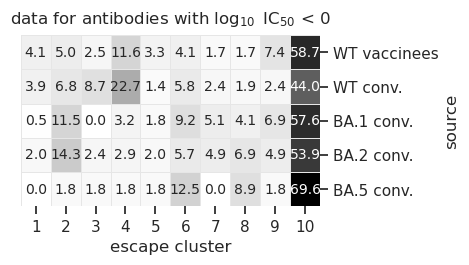

In [18]:
sources = [
    'WT vaccinees', 'WT convalescents',
    'BA.1 convalescents', 
    'BA.2 convalescents', 'BA.5 convalescents',
]

neut_abs = init_ic50s_df[init_ic50s_df['log_IC50'] < 0]['antibody']
data = (
    ic50s_df[ic50s_df['antibody'].isin(neut_abs)]
    .drop_duplicates(subset='antibody')
    .groupby(['source', 'escape_cluster'], as_index=False)['antibody'].count()
    .pivot_table(
        index='escape_cluster', columns='source',
        values='antibody'
    )
    .fillna(0)
    .apply(lambda col: 100 * col/col.sum())
    .rename(columns={col : col.replace('convalescents', 'conv.') for col in sources})
).T

# Plot the data
sources = [col.replace('convalescents', 'conv.') for col in sources]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data.loc[sources], annot=True, fmt=".1f",
    row_cluster=False, col_cluster=False, cmap=cmap,
    figsize=(5.5,3), annot_kws={"size": 10}, linewidths=0.5, linecolor='0.9'
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set(xlabel='escape cluster', ylabel='source')
ax.set_title('data for antibodies with $\log_{10}$ IC$_{50}$ < 0', y=1.02)
# plt.savefig(f'../results/figures/escape_cluster_source_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Validate predictions using IC50 data

What is the correlation in IC50s between different experiments?

0.87 0.0


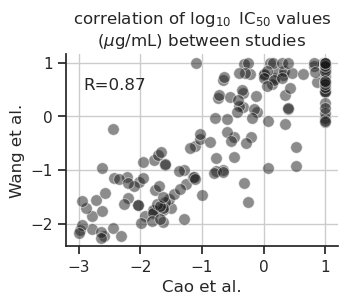

In [19]:
viruses = ['D614G', 'BA.1']
data = (
    ic50s_df[ic50s_df['virus'].isin(viruses)]
    .pivot_table(index=['antibody', 'virus'], columns='study', values='log_IC50')
    .dropna(subset=['Cao et al.', 'Wang et al. pv'])
)

(r, p) = scipy.stats.pearsonr(data['Cao et al.'], data['Wang et al. pv'])
print(round(r, 2), round(p, 2))

# Plot data
plt.figure(figsize=[3.5,2.5])
sns.scatterplot(x='Cao et al.', y='Wang et al. pv', data=data, s=70, alpha=0.5, c='k')
plt.annotate(f'R={round(r,2)}', [-2.92, 0.5])
plt.ylabel('Wang et al.')
plt.title('correlation of $\log_{10}$ IC$_{50}$ values\n($\mu$g/mL) between studies')
plt.grid()
sns.despine()
# plt.savefig(f'../results/figures/validation_study_corr.png', dpi=300, bbox_inches='tight')
plt.show()

Identify viral sequences that match specific variants of concern with experimental IC50 data, then merge their predicted escape scores for each antibody with the dataframe with IC50 data for those same variants and antibodies.

In [20]:
# Make a list of mutations in each strain in the alignmnet relative to WH1
strain_muts_df = escape_scores_df.drop_duplicates('strain').copy()
strain_muts_df['all_aa_substitutions'] = strain_muts_df['all_aa_substitutions'].fillna('')
strain_muts_df['mutations'] = strain_muts_df['all_aa_substitutions'].apply(
    lambda x: set(x.split(' '))
)

# Get a dictionary giving the mutations in each clade
voc_muts_dict = clusters.clusters

# Map strains from IC50 experiments to clades from above dict
voc_to_clade_dict = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Gamma' : 'Gamma',
    'Delta' : 'Delta',
    'Lambda' : '21GLambda',
    'BA.1' : '21K.Omicron',
    'BA.2' : '21L.Omicron',
    'BA.2.75' : '22D',
    'BA.5' : '22B',
    'BQ.1.1' : '22E', # BQ.1 is the founder for 22E; BQ.1.1 is descendant from BQ.1, but has the R346T mutation
    'XBB' : '22F'
}
voc_to_strain_dict = {
    'D614G' : ('Wuhan-Hu-1/2019', [])
}
voc_n_rbd_muts = defaultdict(list)
voc_n_rbd_muts['virus'].append('D614G')
voc_n_rbd_muts['muts'].append([])
voc_n_rbd_muts['n_muts'].append(0)
muts_to_ignore = ['R493Q', 'Q493Q'] # R493R is a reversion
for (voc, clade) in voc_to_clade_dict.items():
    muts = [
        f"{entry['left']}{entry['pos']}{entry['right']}" for entry in
        voc_muts_dict[clade]['mutations']['nonsynonymous']
        if entry['gene'] == 'S'
    ]
    for mut in muts_to_ignore:
        if mut in muts:
            muts.remove(mut)
    if voc == 'BQ.1.1': # BQ.1 is the founder for 22E; BQ.1.1 is descendant from BQ.1, but has the R346T mutation
        muts.append('R346T')
    print(voc, muts)
    voc_n_rbd_muts['virus'].append(voc)
    voc_n_rbd_muts['muts'].append(muts)
    voc_n_rbd_muts['n_muts'].append(len([mut for mut in muts if (331 <= int(mut[1:-1]) <= 531)]))

    # Get the virus with the fewest differences
    strain_muts_df['diffs'] = strain_muts_df['mutations'].apply(
        lambda x: set.symmetric_difference(x, muts)
    )
    strain_muts_df['ndiffs'] = strain_muts_df['diffs'].apply(lambda x: len(x))
    strain_muts_df.sort_values(['ndiffs', 'strain'], inplace=True)
    virus = strain_muts_df['strain'].iloc[0]
    ndiffs = strain_muts_df['ndiffs'].iloc[0]
    diffs = strain_muts_df['diffs'].iloc[0]
    voc_to_strain_dict[voc] = (virus, muts)
    
    if ndiffs > 0:
        print(virus, ndiffs, diffs, '\n')
        raise ValueError()

voc_n_rbd_muts = pd.DataFrame(voc_n_rbd_muts)

# Get predicted escape scores for each VOC relative to each antibody
dfs = []
for (voc, voc_values) in voc_to_strain_dict.items():
    data = escape_scores_df[escape_scores_df['strain'] == voc_values[0]].copy()
    data['virus'] = voc
    dfs.append(data)
pred_ic50s = pd.concat(dfs)

# Then merge the above predictions with the experimental IC50 data on the same VOC/antibody
# combinations
if 'escape_score' not in ic50s_df:
    ic50s_df = (
        ic50s_df
        .merge(
            pred_ic50s[['virus', 'antibody', 'escape_score']],
            on=['antibody', 'virus'], how='left'
        )
        .merge(voc_n_rbd_muts, how='left')
    )

Alpha ['H69-', 'V70-', 'Y144-', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H']
Beta ['D80A', 'D215G', 'L241-', 'L242-', 'A243-', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
Gamma ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I', 'V1176F']
Delta ['T19R', 'G142D', 'E156-', 'F157-', 'R158G', 'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
Lambda ['G75V', 'T76I', 'R246-', 'S247-', 'Y248-', 'L249-', 'T250-', 'P251-', 'G252-', 'D253N', 'L452Q', 'F490S', 'D614G', 'T859N']
BA.1 ['A67V', 'H69-', 'V70-', 'T95I', 'G142-', 'V143-', 'Y144-', 'Y145D', 'N211-', 'L212I', 'G339D', 'S371L', 'S373P', 'S375F', 'K417N', 'N440K', 'G446S', 'S477N', 'T478K', 'E484A', 'Q493R', 'G496S', 'Q498R', 'N501Y', 'Y505H', 'T547K', 'D614G', 'H655Y', 'N679K', 'P681H', 'N764K', 'D796Y', 'N856K', 'Q954H', 'N969K', 'L981F']
BA.2 ['T19I', 'L24-', 'P25-', 'P26-', 'A27S', 'G142D', 'V213G', 'G339D', 'S371F', 'S373P', 'S375F', 'T376A', 'D405N', 'R408S', 'K417N', 'N440

Examine RBD mutations in each of the above variants and compare strains to make sure mutation differences match those reported by [Cao et al.](https://www.nature.com/articles/s41586-022-05644-7#Sec8). Supplementary Table 3 reports RBD mutations in BA.2.75, BQ.1.1, and XBB relative to BA.2 and BA.5. The reported mutations match the ones from above. Though the table does not give BA.1, BA.2, or BA.5 sequences. The Methods section on estimating preferences defines BA.5 RBD mutations relative to BA.2, and it matches the ones from above. An earlier [Cao et al.](https://www.nature.com/articles/s41586-022-04980-y) study with overlap in neutralizationd ata reports mutations in BA.1 and BA.2 variants. They match the mutations from above, except that BA.2 is reported as having the G446S mutation. This seems to be an error, as Supplementary Table 3 from above reports some variants as having G446S mutations relative to the BA.2 variant.

In [21]:
rbd_muts_dict = {}
for (i, row) in voc_n_rbd_muts.iterrows():
    rbd_muts = set([mut for mut in row['muts'] if 331 <= int(mut[1:-1]) <= 551])
    rbd_muts_dict[row['virus']] = rbd_muts
    print(row['virus'], rbd_muts)

D614G set()
Alpha {'N501Y'}
Beta {'K417N', 'E484K', 'N501Y'}
Gamma {'N501Y', 'E484K', 'K417T'}
Delta {'L452R', 'T478K'}
Lambda {'L452Q', 'F490S'}
BA.1 {'Q498R', 'N501Y', 'E484A', 'K417N', 'S375F', 'G446S', 'S477N', 'Y505H', 'N440K', 'T547K', 'S373P', 'G496S', 'Q493R', 'S371L', 'G339D', 'T478K'}
BA.2 {'Q498R', 'S371F', 'E484A', 'K417N', 'S375F', 'D405N', 'R408S', 'S477N', 'N440K', 'Y505H', 'S373P', 'N501Y', 'Q493R', 'T478K', 'G339D', 'T376A'}
BA.2.75 {'Q498R', 'N460K', 'S371F', 'G339H', 'E484A', 'K417N', 'S375F', 'R408S', 'G446S', 'S477N', 'N440K', 'Y505H', 'S373P', 'N501Y', 'T478K', 'D405N', 'T376A'}
BA.5 {'L452R', 'Q498R', 'S371F', 'E484A', 'F486V', 'K417N', 'S375F', 'D405N', 'R408S', 'S477N', 'N440K', 'Y505H', 'S373P', 'N501Y', 'T478K', 'G339D', 'T376A'}
BQ.1.1 {'L452R', 'K444T', 'R346T', 'K417N', 'D405N', 'G339D', 'T376A', 'Q498R', 'N460K', 'E484A', 'S375F', 'S373P', 'S371F', 'R408S', 'N501Y', 'F486V', 'S477N', 'Y505H', 'N440K', 'T478K'}
XBB {'L368I', 'F486S', 'F490S', 'R346T', 'K41

In [22]:
ref_strain = 'BA.2'
derived_strain = 'BA.2.75'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in BA.2.75 not in BA.2:
{'G339H', 'N460K', 'G446S'}
muts in BA.2 not in BA.2.75:
{'Q493R', 'G339D'}


In [23]:
ref_strain = 'BA.2'
derived_strain = 'BA.5'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in BA.5 not in BA.2:
{'L452R', 'F486V'}
muts in BA.2 not in BA.5:
{'Q493R'}


In [24]:
ref_strain = 'BA.5'
derived_strain = 'BQ.1.1'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in BQ.1.1 not in BA.5:
{'N460K', 'K444T', 'R346T'}
muts in BA.5 not in BQ.1.1:
set()


In [25]:
ref_strain = 'BA.2'
derived_strain = 'XBB'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in XBB not in BA.2:
{'L368I', 'N460K', 'F486S', 'F490S', 'G339H', 'R346T', 'G446S', 'V445P'}
muts in BA.2 not in XBB:
{'Q493R', 'G339D'}


In [26]:
ref_strain = 'BA.1'
derived_strain = 'BA.2'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in BA.2 not in BA.1:
{'R408S', 'S371F', 'D405N', 'T376A'}
muts in BA.1 not in BA.2:
{'G496S', 'G446S', 'S371L', 'T547K'}


Do experimentally IC50 values support the predicted escape scores?

In [27]:
# Plotting params
virus_order = [
    'D614G',
    'Alpha', 'Beta', 'Gamma',
    'Lambda', 'Delta', 
    'Omicron',
    'BA.1', 'BA.2', 'BA.2.75',
    'BA.5', 'BQ.1.1',
    'XBB', 'XBB.1.5'
]
studies = [
    'Wang et al. pv',
    #'Wang et al. av',
    'Cao et al.',
]

for (study, data) in ic50s_df.groupby('study'):

    # Select antibodies with a logIC50 below zero for D614G
    pivoted_data = data.pivot(
        index='antibody', columns='virus', values='log_IC50'
    )
    antibodies_to_plot = list(set(pivoted_data[
        (pivoted_data['D614G'] <= 0)
    ].index.values))
    print(study, len(pivoted_data), len(antibodies_to_plot))

Cao et al. 1603 846
Wang et al. av 90 68
Wang et al. pv 90 66


In [28]:
with open('../results/abs_with_large_diffs_Cao.txt') as f:
    abs_with_large_diffs_Cao = [line.strip() for line in f.readlines()]
print(len(abs_with_large_diffs_Cao))

with open('../results/abs_with_large_diffs_Wang.txt') as f:
    abs_with_large_diffs_Wang = [line.strip() for line in f.readlines()]
print(len(abs_with_large_diffs_Wang))

81
16


1


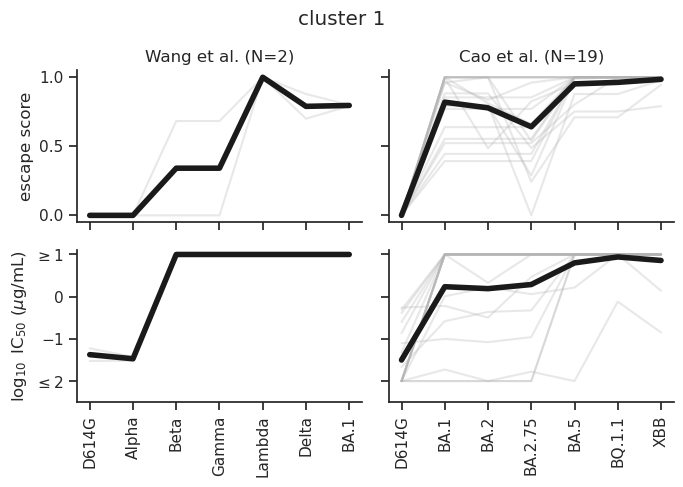

2


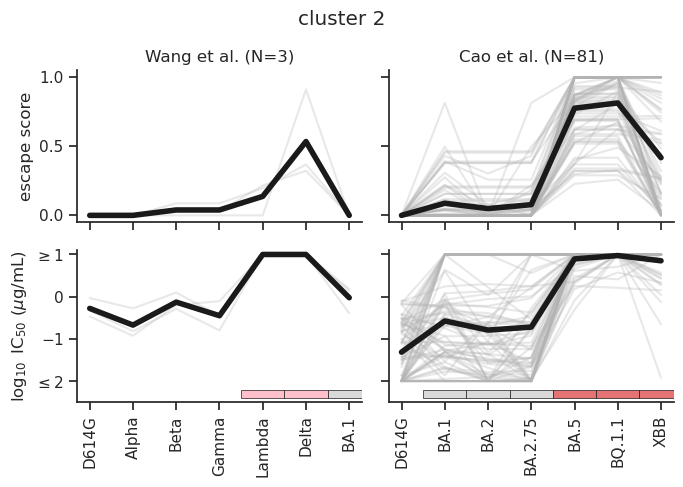

3


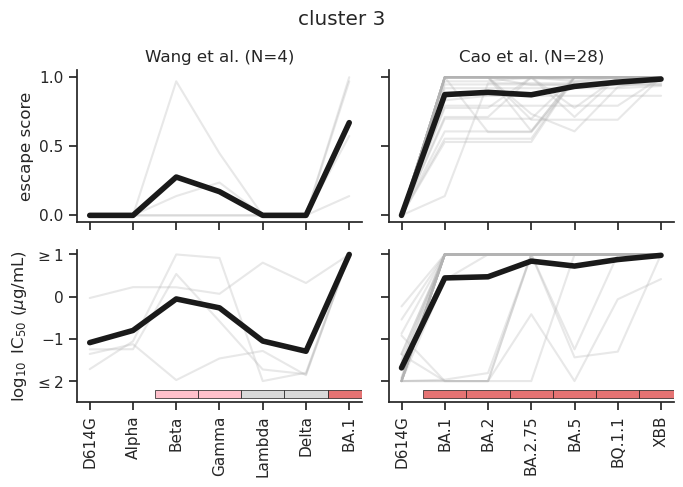

4


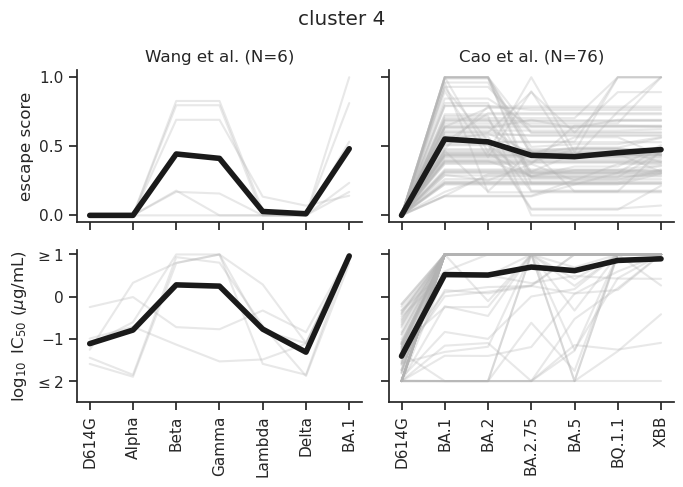

5


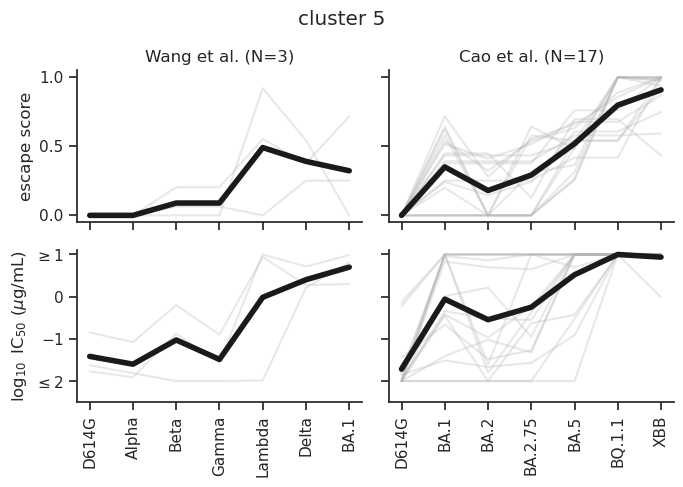

6
1 122
58 122


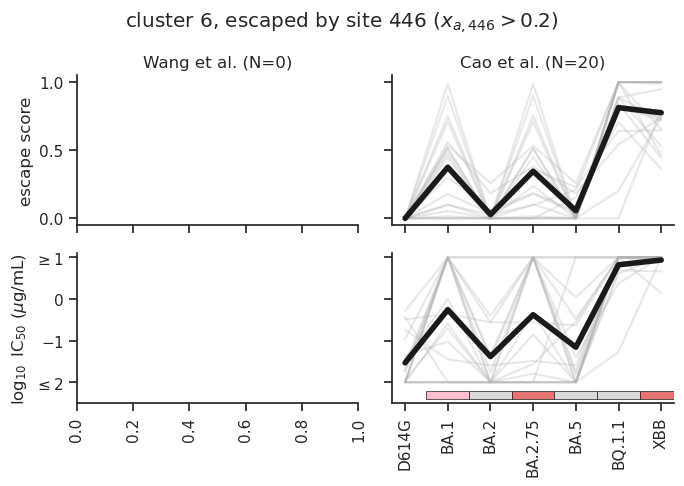

7
Skipping 7 Wang et al. pv


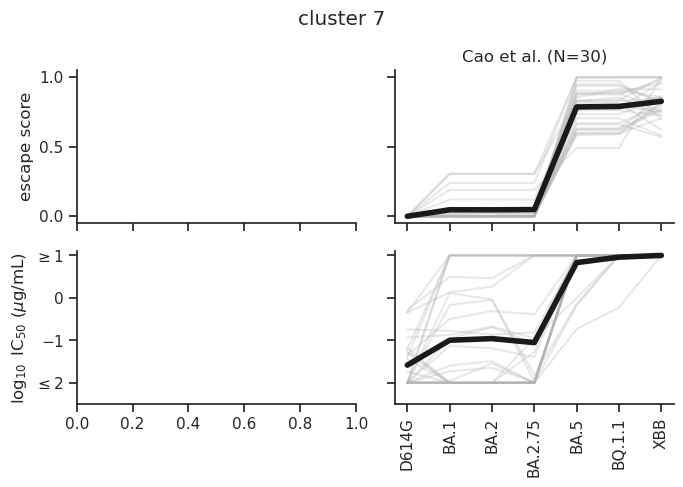

8


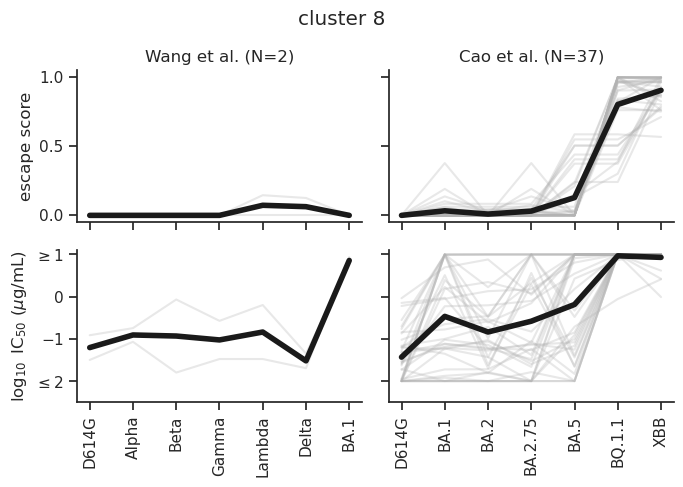

9


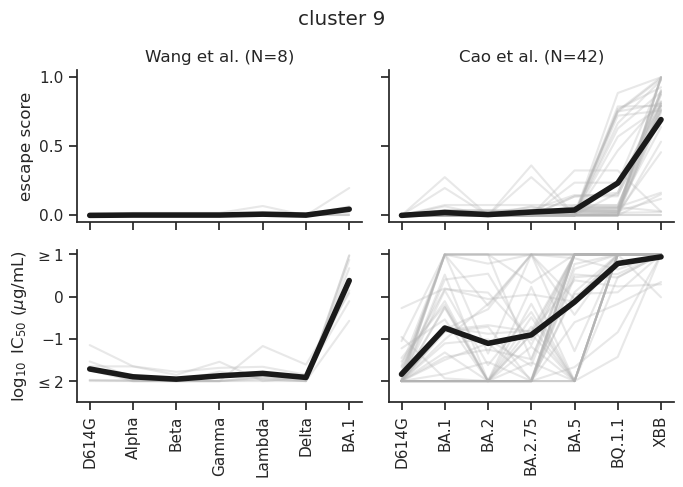

10


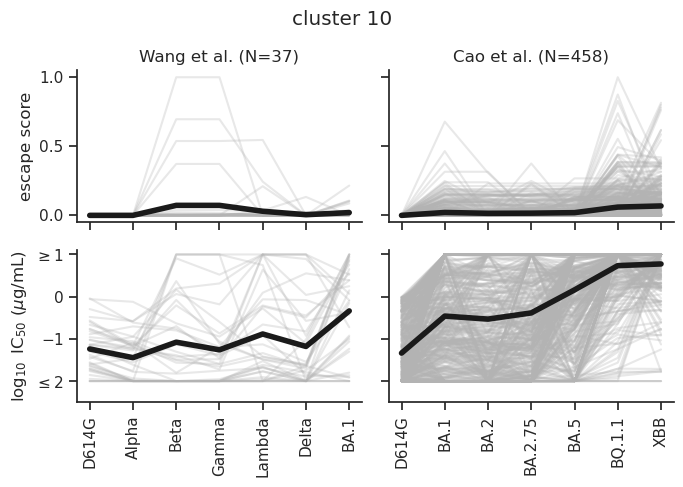

In [29]:
# Plotting params
virus_order = [
    'D614G',
    'Alpha', 'Beta', 'Gamma',
    'Lambda', 'Delta', 
    'Omicron',
    'BA.1', 'BA.2', 'BA.2.75',
    'BA.5', 'BQ.1.1',
    'XBB', 'XBB.1.5'
]
studies = [
    'Wang et al. pv',
    'Cao et al.',
]
study_pal = {
    'Wang et al. pv' : '#0173b2',
    'Cao et al.' : 'firebrick'
}

clusters_to_plot = list(range(1, 11))
plot_cluster_6_446_subset = True
ic50_corr_dict = defaultdict(list)
ab_corr_dict = defaultdict(list)

for cluster in clusters_to_plot:

    print(cluster)
    (fig, axs) = plt.subplots(
        ncols=2, nrows=2, figsize=[7,5], sharex='col', sharey='row',
        gridspec_kw={'width_ratios': [1, 1]}
    )
    axs = axs.reshape(-1)

    for (ax_i, study) in enumerate(studies):
        
        # Get IC50 data
        data = ic50s_df[
            (ic50s_df['escape_cluster'] == cluster) &
            (ic50s_df['virus'].isin(virus_order)) &
            (ic50s_df['study'] == study)
        ].copy()
        if len(data) == 0:
            print('Skipping', cluster, study)
            continue
        data['clipped_log_IC50'] = data['log_IC50'].clip(lower=-2)
        data['clipped_delta_log_IC50'] = data['delta_log_IC50'].clip(lower=0, upper=3)

        # Sort the viruses for the x-axis
        virus_index_dict = {
            virus : i
            for (i, virus) in enumerate(virus_order)
        }
        data['order'] = data['virus'].apply(lambda x: virus_index_dict[x])
        data.sort_values('order', inplace=True)
        hue_order = sorted(data['antibody'].unique())
        
        # Select antibodies with a logIC50 below zero for D614G
        pivoted_data = data.pivot(
            index='antibody', columns='virus', values='log_IC50'
        )
        antibodies_to_plot = set(pivoted_data[
            (pivoted_data['D614G'] <= 0)
        ].index.values)
        #antibodies_to_plot = [ab for ab in antibodies_to_plot if ab in list(abs_with_large_diffs_Cao)]
        if len(antibodies_to_plot) == 0:
            continue

        data = data[data['antibody'].isin(antibodies_to_plot)]

        # Compute the correlation between escape scores and IC50s, or number
        # of mutations in a variant and IC50s
        IC50_metric = 'log_IC50'
        ab_rs = []
        for (antibody, ab_data) in data.groupby('antibody'):
            r = ab_data['escape_score'].corr(ab_data[IC50_metric])
            r_n_muts = ab_data['n_muts'].corr(ab_data[IC50_metric])
            ab_corr_dict['cluster'].append(cluster)
            ab_corr_dict['study'].append(study)
            ab_corr_dict['antibody'].append(antibody)
            ab_corr_dict['r'].append(round(r, 2))
            ab_corr_dict['r_n_muts'].append(round(r_n_muts, 2))
            ab_corr_dict['max_escape_score'].append(ab_data['escape_score'].max())


        ################
        # Make line plots
        ################

        pivoted_data = data.pivot(
            index='antibody', columns='virus', values='escape_score' # 'log_IC50' # 
        )

        # For cluster 6, select a subset of antibodies to plot in the line plot
        if cluster == 6:
            subset_site = 446
            antibody_subset = site_escape_df[
                (site_escape_df['site'] == subset_site) &
                (site_escape_df['normalized_escape'] > 0.2)
            ]['antibody'].unique()
            if plot_cluster_6_446_subset:
                data = data[data['antibody'].isin(antibody_subset)]
            else:
                data = data[~data['antibody'].isin(antibody_subset)]
            print(len(antibodies_to_plot), len(antibody_subset))

        # Plot data
        ic50_metric = 'clipped_log_IC50' # 'clipped_delta_log_IC50' # 'delta_log_IC50' # 
        escape_metric = 'escape_score' # 'n_muts' # 
        for metric in [escape_metric, ic50_metric]:
            if metric == escape_metric:
                n_abs = len(data['antibody'].unique())
                axs[ax_i].set(title=f"{study.replace(' pv', '')} (N={n_abs})")
                metric_ax_i = ax_i
            else:
                # axs[ax_i+2].axhline(1, ls='--', lw=0.5, zorder=10)
                # axs[ax_i+2].axhline(-2, ls='--', lw=0.5, zorder=10)
                metric_ax_i = ax_i + 2
            if len(data) == 0:
                continue
            sns.lineplot(
                x='virus', y=metric, data=data, ax=axs[metric_ax_i],
                units='antibody', estimator=None, c='0.7', alpha=0.3
                #hue='antibody', hue_order=hue_order,
            )
            sns.lineplot(
                x='virus', y=metric, data=data, ax=axs[metric_ax_i],
                linewidth=4, estimator='mean', errorbar=None, color='k' # color=study_pal[study],
            )

        for tick in axs[ax_i+2].get_xticklabels():
            tick.set_rotation(90)

    # Add rectangles
    cluster_rec_params = {
        2 : [
            (2, 3.5, 'pink'), (2, 4.5, 'pink'),
            (2, 5.5, '0.85'), (3, 0.5, '0.85'), (3, 1.5, '0.85'), (3, 2.5, '0.85'),
            (3, 3.5, '#E57373'), (3, 4.5, '#E57373'), (3, 5.5, '#E57373'),
        ],
        3 : [
            (2, 1.5, 'pink'), (2, 2.5, 'pink'),
            (2, 3.5, '0.85'), (2, 4.5, '0.85'),
            (2, 5.5, '#E57373'), (3, 0.5, '#E57373'), (3, 1.5, '#E57373'), (3, 2.5, '#E57373'),
            (3, 3.5, '#E57373'), (3, 4.5, '#E57373'), (3, 5.5, '#E57373'),
        ],
        6 : [
            #(2, 1.5, 'pink'), (2, 2.5, 'pink'),
            #(2, 3.5, '0.85'), (2, 4.5, '0.85'),
            (2, 5.5, 'pink'), (3, 0.5, 'pink'),
            (3, 1.5, '0.85'), (3, 2.5, '#E57373'),
            (3, 3.5, '0.85'), (3, 4.5, '0.85'), (3, 5.5, '#E57373'),
        ],
    }
    if cluster in cluster_rec_params:
        if (cluster == 6) and (plot_cluster_6_446_subset == False):
            rec_params = []
        else:
            rec_params = cluster_rec_params[cluster]
        for (ax_i, x, c) in rec_params:
            rect = patches.Rectangle((x, -2.4), 1, 0.2, linewidth=0.5, edgecolor='k', facecolor=c)
            axs[ax_i].add_patch(rect)

    # Tweak plots
    axs[0].set(yticks=[0, 0.5, 1], ylabel='escape score')
    axs[1].set(ylabel='')
    axs[2].set(
        xlabel='', ylim=[-2.5, 1.1], yticks=[-2, -1, 0, 1], ylabel=r'$\log_{10}$ IC$_{50}$ ($\mu$g/mL)'
    )
    axs[2].set_yticklabels(['$\leq2$', '$-1$', '$0$', '$\geq1$'])
    axs[3].set(xlabel='', ylabel='')
    if cluster == 6:
        if plot_cluster_6_446_subset:
            title = 'cluster 6, escaped by site 446 ($x_{a,446}>0.2$)'
        else:
            title = 'cluster 6, not escaped by site 446 ($x_{a,446}\leq0.2$)'
    else:
        title = f'cluster {cluster}'
    plt.suptitle(title, y=0.97)
    plt.tight_layout()
    sns.despine()
    # if cluster == 6:
    #     if plot_cluster_6_446_subset:
    #         # plt.savefig(f'../results/figures/validation_cluster_{cluster}_446.png', dpi=300, bbox_inches='tight')
    #     else:
    #         # plt.savefig(f'../results/figures/validation_cluster_{cluster}_not_446.png', dpi=300, bbox_inches='tight')
    # else:
    #     # plt.savefig(f'../results/figures/validation_cluster_{cluster}.png', dpi=300, bbox_inches='tight')
    plt.show()

ab_corr_df = pd.DataFrame(ab_corr_dict)
ab_corr_df['r'] = ab_corr_df['r'].fillna(0)
ab_corr_df['delta_r'] = ab_corr_df['r_n_muts'] - ab_corr_df['r']
ab_corr_df.to_csv('../results/ab_corr_df_v2.csv', index=False)

In [30]:
# Get list of cluster 6 antibodies
cluster = 6
data = ic50s_df[
    (ic50s_df['study'] == 'Cao et al.') &
    (ic50s_df['escape_cluster'] == cluster)
].copy()
pivoted_data = data.pivot(
    index='antibody', columns='virus', values='log_IC50'
)
antibodies_to_plot = set(pivoted_data[
    (pivoted_data['D614G'] <= 0)
].index.values)

print('N antibodies with data in cluster 6:', len(antibodies_to_plot))

antibody_subset_446 = site_escape_df[
    (site_escape_df['antibody'].isin(antibodies_to_plot)) &
    (site_escape_df['site'] == 446) &
    (site_escape_df['escape_cluster'] == 6) &
    (site_escape_df['normalized_escape'] > 0.2)
]['antibody'].unique()
print('N antibodies escaped by 446:', len(antibody_subset_446))

antibody_subset_346 = site_escape_df[
    (site_escape_df['antibody'].isin(antibodies_to_plot)) &
    (site_escape_df['site'] == 346) &
    (site_escape_df['escape_cluster'] == 6) &
    (site_escape_df['normalized_escape'] > 0.2)
]['antibody'].unique()
print('N antibodies escaped by 346:', len(antibody_subset_346))

print('overlap:', len(set.intersection(set(antibody_subset_446), set(antibody_subset_346))))

N antibodies with data in cluster 6: 58
N antibodies escaped by 446: 20
N antibodies escaped by 346: 24
overlap: 7


Plot correlation coefficients by cluster and study

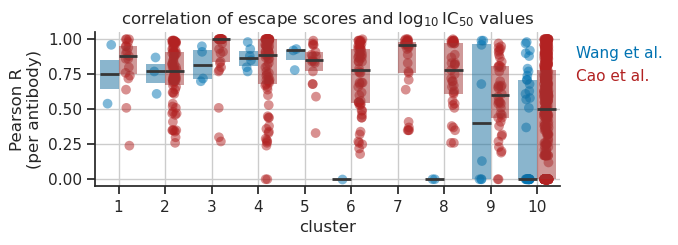

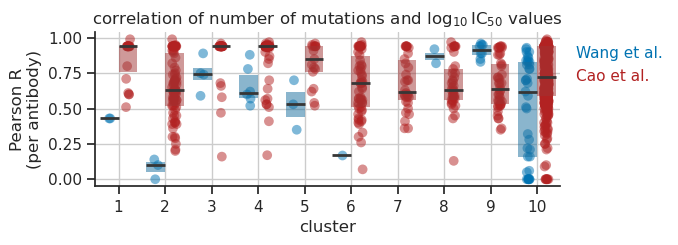

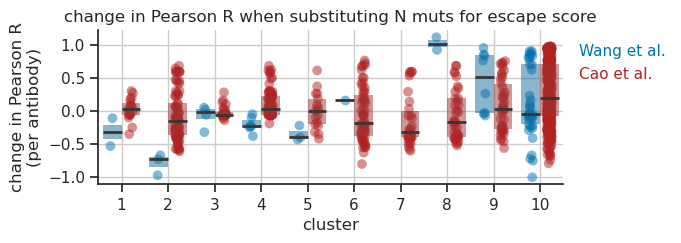

In [31]:
study_pal = {
    'Wang et al.' : '#0173b2',
    'Cao et al.' : 'firebrick'
}
plot_vars = [
    ('escape scores', 'r', 0),
    ('number of mutations', 'r_n_muts', 0),
    ('delta R', 'delta_r', -1),
]
for (title_var, corr_metric, lower_lim) in plot_vars:
    data = ab_corr_df.copy()
    data[corr_metric] = data[corr_metric].clip(lower=lower_lim)
    data['study'] = data['study'].replace('Wang et al. pv', 'Wang et al.')
    plt.figure(figsize=[6,2])
    hue_order = ['Wang et al.', 'Cao et al.']
    sns.stripplot(
        x='cluster', y=corr_metric, data=data,
        hue='study', hue_order=hue_order, palette=study_pal,
        dodge=True, alpha=0.5, s=7
    )
    sns.boxplot(
        x='cluster', y=corr_metric, data=data,
        hue='study', hue_order=hue_order, palette=study_pal,
        legend=False, showfliers=False, whis=0, linewidth=0,
        medianprops={"linewidth": 2}, boxprops={'alpha':.5}, zorder=10,
    )
    ax = plt.gca()
    if corr_metric == 'delta_r':
        ylabel = 'change in Pearson R\n(per antibody)'
        title = 'change in Pearson R when substituting N muts for escape score'
    else:
        ylabel = 'Pearson R\n(per antibody)'
        title = f'correlation of {title_var} and ' + r'$\log_{10}\text{IC}_{50}$ values'
    ax.set(ylabel=ylabel, title=title)
    ax.legend(
        frameon=False, markerscale=0, labelcolor='linecolor',
        loc='upper right', bbox_to_anchor=(1.25,1)
    )
    plt.grid()
    sns.despine()
    # plt.savefig(f'../results/figures/validation_corr_{corr_metric}.png', dpi=300, bbox_inches='tight')
    plt.show()

Write an output file giving the maximum values of escape trajectories.

In [32]:
data = traj_df.groupby('antibody', as_index=False)['mean_escape'].max()
data['method'] = 'aa'
data.to_csv('../results/traj_max_v2.csv', index=False)


Examine the distribution of maximum values.

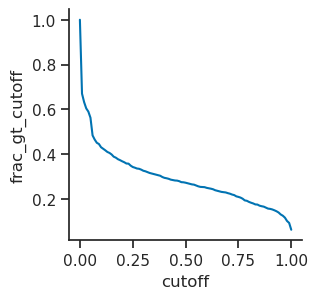

In [33]:
# Compute fraction of trajectories passing a given cutoff
c_dist_dict = defaultdict(list)
data = traj_df.groupby('antibody', as_index=False)['mean_escape'].max()
cutoffs = np.arange(0, 1.01, 0.01)
for cutoff in cutoffs:
    c_dist_dict['cutoff'].append(cutoff)
    c_dist_dict['frac_gt_cutoff'].append(sum(data['mean_escape'] >= cutoff)/len(data))
c_dist_df = pd.DataFrame(c_dist_dict)
c_dist_df.to_csv('../results/c_dist_df_v2.csv', index=False)

# Plot distribution
plt.figure(figsize=[3,3])
sns.lineplot(x='cutoff', y='frac_gt_cutoff', data=c_dist_df)
sns.despine()
plt.show()